# Problem Set 4

In [1]:
import numpy as np 
import scipy.interpolate
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from scipy.signal import find_peaks 

In [2]:
%matplotlib notebook

## Visualizing Vector and Scalar Fields

## a)

Since Gravitational Force is conservative, $\vec{F}$ is derivable from the potential energy:

$$
\begin{aligned}
    \vec{F}(\vec{r}) &= -\vec{\nabla}U(\vec{r})\\\\
                     & = -(\frac{\partial U}{\partial x}\hat{x}+\frac{\partial U}{\partial y}\hat{y})\\\\
                     & = -(\frac{\partial}{\partial x}(-\frac{GMm}{|\vec{r}|})\hat{x} + \frac{\partial}{\partial y}(-\frac{GMm}{|\vec{r}|})\hat{y})\\\\
                     &= GMm(\frac{\partial}{\partial x}\frac{1}{\sqrt{x^2+y^2}}\hat{x}+\frac{\partial}{\partial y}\frac{1}{\sqrt{x^2+y^2}}\hat{y})\\\\
                     &= GMm(2x(-\frac{1}{2}(x^2+y^2)^{-\frac{3}{2}})\hat{x} + 2y(-\frac{1}{2}(x^2+y^2)^{-\frac{3}{2}})\hat{y})\\\\
                     & = -\frac{GMmx}{\sqrt{x^2 + y^2}^3}\hat{x} -\frac{GMmy}{\sqrt{x^2 + y^2}^3}\hat{y}\\\\
    \vec{F}(\vec{r}) & = (-\frac{GMmx}{|\vec{r}|^3})\hat{x}+(-\frac{GMmx}{|\vec{r}|^3})\hat{y}\\\\
\end{aligned}
$$
Thus, the x and y force components experienced by mass $m$ for any position $\vec{r}$ relative to mass $M$ is the following:


$$
\begin{aligned}
    F_x &= -\frac{GMmx}{|\vec{r}|^3}\\\\
    F_y &= -\frac{GMmy}{|\vec{r}|^3}
\end{aligned}
$$

## b)

From the example visualization below, we can see that the gravatiational force vector field $\vec{F}(\vec{r})$ has the following key features:
1. **Central**:  
$\vec{F}(\vec{r})$ is directed towards a single point called the centre of force: $\vec{F}(\vec{r}) = -|\vec{F}(\vec{r})|\hat{r}$  
2. **Spherically Symmetric**:  
The force depends only on its radial coordinates: $\vec{F}(\vec{r}) = \vec{F}(r)$.
3. the magnitude of $\vec{F}$ is inversely related to $|\vec{r}|$
  
The gravitational potential scalar field $U(\vec{r}) = U(r)$ is also **sphereically symmetric** since it's only dependent on the radial coordinate. The closer to the centre of gravitational force, the lower the gravitational potential.

Define helper functions.

In [3]:
def gravitationalPotential(x_array, y_array, x_0, y_0, G=1., m_0=1., m=1.):
    """Compute gravitational potential scalar field and force vector field.
    
    Parameters
    ----------
    x_array : `list` [`float`]
        Array of x-coordinate positions to evaluate fields.
    y_array : `list` [`float`]
        Array of y-coordinate positions to evaluate fields.
    x_0 : `float`
        x-coordinate of the mass producing fields.
    y_0 : `float`
        y-coordinate of the mass producting fields.
    
    Returns
    -------
    xx : `numpy.ndarray` [`numpy.float64`]
        2D array of x-coordinates.
    yy : `numpy.ndarray` [`numpy.float64`]
        2D array of y-coordinates.
    uu : `numpy.ndarray` [`numpy.float64`]
        2D array of potential scalar field values.
    f_xx : `numpy.ndarray` [`numpy.float64`]
        2D array of force vector field x-component values.
    f_yy : `numpy.ndarray` [`numpy.float64`]
        2D array of force vector field y-component values.
    """
    
    xx, yy = np.meshgrid(x, y)
    
    rr_xx = xx - x_0
    rr_yy = yy - y_0
    rr = np.sqrt(rr_xx**2 + rr_yy**2)
    
    uu = - G * m_0 * m / rr
    f_xx = - G * m_0 * m * rr_xx / rr**3
    f_yy = - G * m_0 * m * rr_yy / rr**3
    
    return xx, yy, uu, f_xx, f_yy

In [4]:
def symlog2D(x, y):
    """Compute log-scaling for a vector field."""
    r = np.sqrt(x**2 + y**2)
    a = np.log10(r)
    a -= np.min(a)
    return a * (x/r), a * (y/r) 

In [5]:
def logQuiver(xx, yy, uu, vv, **kwargs):
    """Make quiver plot with log-scaled arrow lengths."""
    log_uu, log_vv = symlog2D(uu, vv)
    plt.quiver(xx, yy, log_uu, log_vv, **kwargs)

Example visualization.

<IPython.core.display.Javascript object>


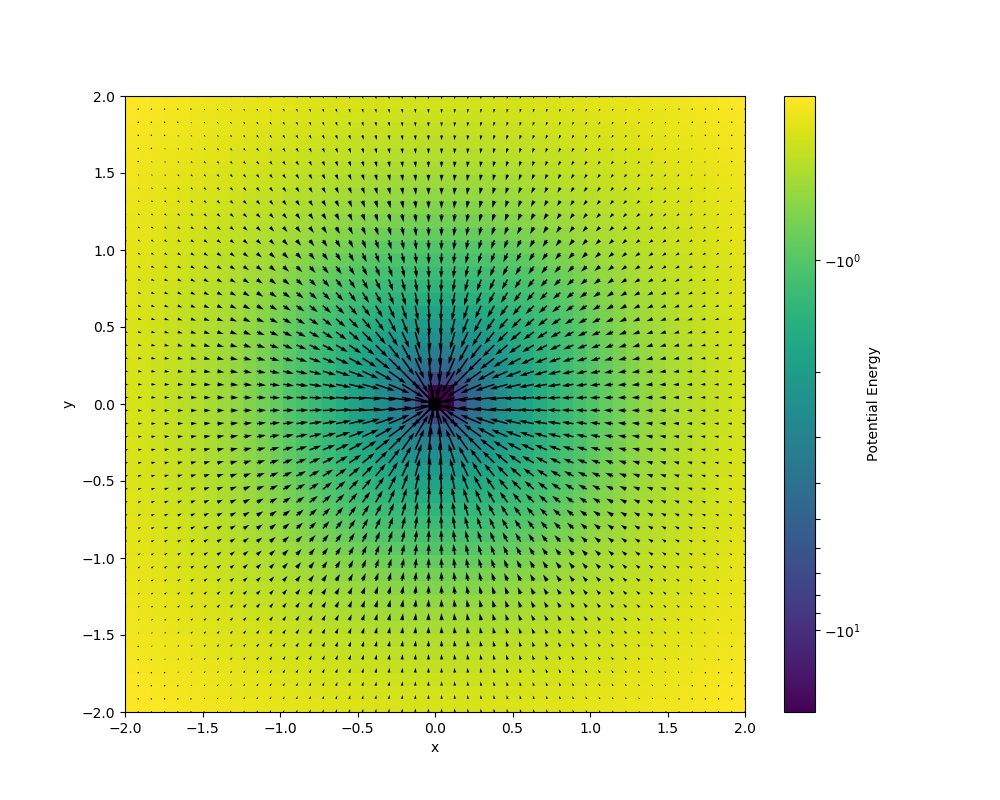

Text(0, 0.5, 'y')

In [6]:
n = 48
x = np.linspace(-2., 2., n)
y = np.linspace(-2., 2., n)
x_1, y_1 = 0., 0.

xx, yy, vv, f_xx, f_yy = gravitationalPotential(x, y, x_1, y_1)

plt.figure(figsize=(10, 8))
plt.pcolor(xx, yy, vv, norm=SymLogNorm(1.,vmin=vv.min(), vmax=vv.max()))
plt.colorbar(label='Potential Energy')
logQuiver(xx, yy, f_xx, f_yy)
plt.xlabel('x')
plt.ylabel('y')

## c)

Suppose two masses $m_1$ and $m_2$ placed near each other on a plane. We define the following method to combine the effect on the gravitational potential scalar field and force vector field of the masses, performing vector addition on force vectors produced by $m_1$ and $m_2$ at every position.

In [7]:
# add two potential fields up, performing vector addition
def addPotential(pf_1, pf_2):
    
    # only add the x, y components of force vector
    result = list(map(lambda x, y: x + y, pf_1, pf_2))
    
    # not adding the x, y postions of two masses
    result[0] = pf_1[0]
    result[1] = pf_1[1]
    
    return result

Frist try two equal masses placed near each other

<IPython.core.display.Javascript object>


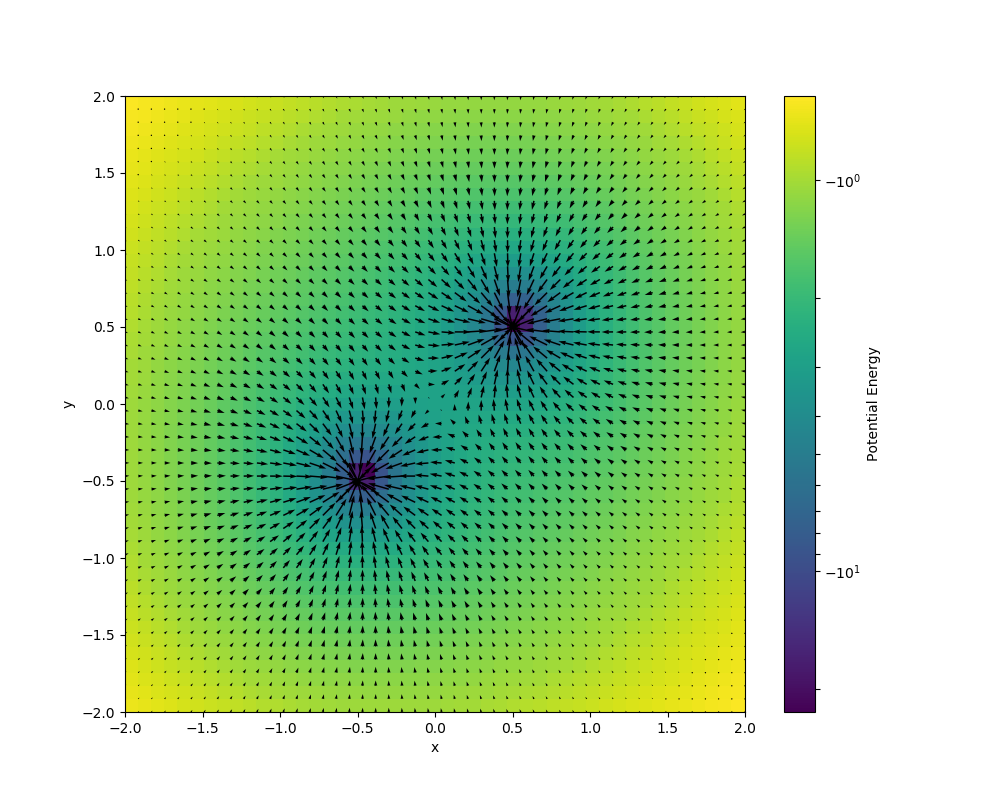

Text(0, 0.5, 'y')

In [8]:
n = 48
x = np.linspace(-2., 2., n)
y = np.linspace(-2., 2., n)
x_1, y_1 = -.5, -.5
x_2, y_2 = .5, .5

xx, yy, vv, f_xx, f_yy = addPotential(gravitationalPotential(x, y, x_1, y_1), 
                                      gravitationalPotential(x, y, x_2, y_2))

plt.figure(figsize=(10, 8))
plt.pcolor(xx, yy, vv, norm=SymLogNorm(1.,vmin=vv.min(), vmax=vv.max()))
plt.colorbar(label='Potential Energy')
logQuiver(xx, yy, f_xx, f_yy)
plt.xlabel('x')
plt.ylabel('y')

Then, try placing $m_1 = 1$ and $m_2 = 5$ near each other

<IPython.core.display.Javascript object>


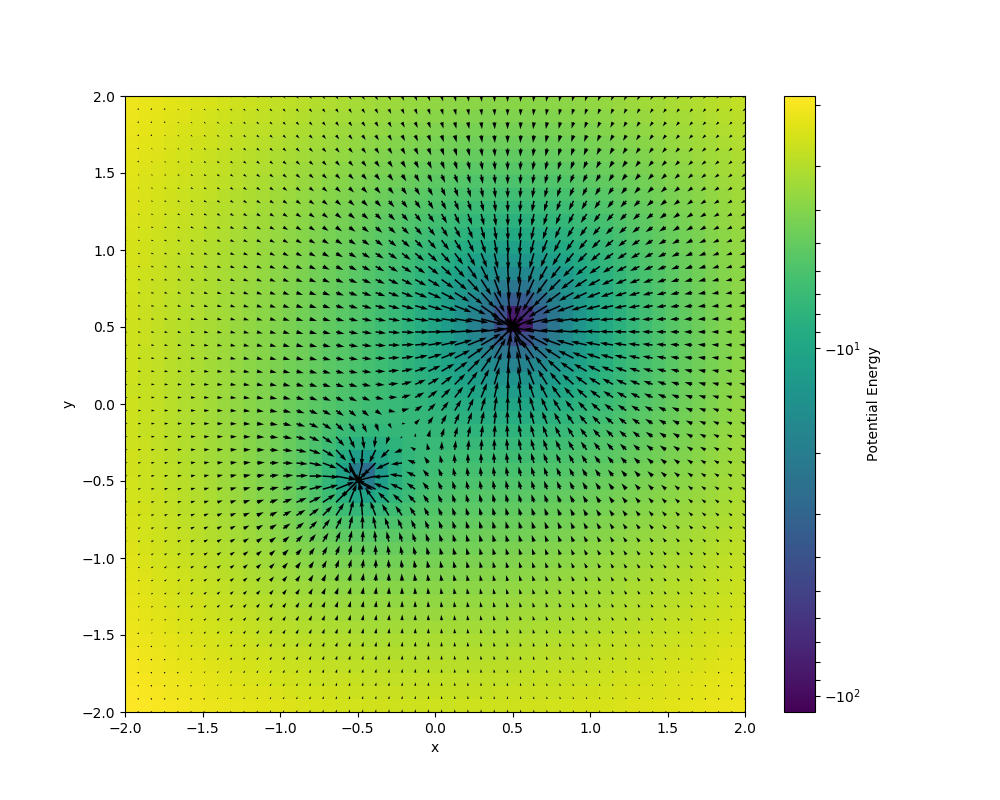

Text(0, 0.5, 'y')

In [9]:
n = 48
x = np.linspace(-2., 2., n)
y = np.linspace(-2., 2., n)
x_1, y_1 = -.5, -.5
x_2, y_2 = .5, .5

xx, yy, vv, f_xx, f_yy = addPotential(gravitationalPotential(x, y, x_1, y_1), 
                                      gravitationalPotential(x, y, x_2, y_2, m = 5))

plt.figure(figsize=(10, 8))
plt.pcolor(xx, yy, vv, norm=SymLogNorm(1.,vmin=vv.min(), vmax=vv.max()))
plt.colorbar(label='Potential Energy')
logQuiver(xx, yy, f_xx, f_yy)
plt.xlabel('x')
plt.ylabel('y')

### Explanation

We can see that in both cases, there exisits an equilibrium position on the line connecting the positions of $m_1$ and $m_2$, where there is zero gravitational force vector.

The equilibrium point is a saddle point. It is unstable because at any poisitons other than the equilibrium point along the line connecting the positions of two masses, the force vectors are directed away from the equilibrium point; thus, once an object moves away from the equilibrium point, it will experience forces directed away from the equilibrium point and not return to the equilibrium. Thus, the equilibrium point is unstable.

## Solutions for the Harmonic Oscillator

Letting $\omega = \sqrt{\frac{k}{m}}$

## a)

$$
\begin{aligned}
    x &= C_1e^{i\omega t}+C_2e^{-i\omega t}\\\\
    \dot{x} &= \frac{d}{dt}(C_1e^{i\omega t}+C_2e^{-i\omega t})\\
            &= i\omega C_1e^{i\omega t} - i\omega C_2e^{-i\omega t}\\\\
    \ddot{x} &= \frac{d}{dt}\dot{x}\\
             &= \frac{d}{dt}(i\omega C_1e^{i\omega t} - i\omega C_2e^{-i\omega t})\\
             &= (i\omega)^2C_1e^{i\omega t} + (i\omega)^2C_2e^{-i\omega t}\\
             &= -\omega^2(C_1e^{i\omega t}+C_2e^{-i\omega t})\\
             &= -\omega^2x\\
             &= -\frac{k}{m}x\\\\
    m\ddot{x} &= -kx
\end{aligned}
$$

## b)

$$
\begin{aligned}
    x &= A\cos(\omega t - \delta)\\\\
    \dot{x} &= \frac{d}{dt}(A\cos(\omega t - \delta))\\
            &= -\omega A\sin(\omega t - \delta) \\\\
    \ddot{x} &= \frac{d}{dt}\dot{x}\\
             &= \frac{d}{dt}(-\omega A\sin(\omega t - \delta))\\
             &= -\omega^2 (A\cos(\omega t - \delta))\\
             &= -\omega^2x\\
             &= -\frac{k}{m}x\\\\
    m\ddot{x} &= -kx
\end{aligned}
$$

## c)

$$
\begin{aligned}
    x &= \Re Ae^{i(\omega t - \delta)}\\\\
    \dot{x} &= \frac{d}{dt}(A\Re(\cos(\omega t - \delta) + i\sin(\omega t - \delta)))\\
            &= \frac{d}{dt}(A\cos(\omega t - \delta)) \\
            &= -\omega A\sin(\omega t - \delta) \\\\
    \ddot{x} &= \frac{d}{dt}\dot{x}\\
             &= \frac{d}{dt}(-\omega A\sin(\omega t - \delta))\\
             &= -\omega^2 (A\cos(\omega t - \delta))\\
             &= -\omega^2x\\
             &= -\frac{k}{m}x\\\\
    m\ddot{x} &= -kx
\end{aligned}
$$

## Damped Oscillator

The natural angular frequency $\omega_0 = \frac{2\pi}{\tau_0} = 2\pi \cdot s^{-1}$  
The angular frequency of the damped oscillator $\omega_1 = \frac{2\pi}{\tau_1} = \frac{2\pi}{1.001} \cdot s^{-1}$  
  
For damped oscillations, $\beta = \sqrt{\omega_0^2-\omega_1^2}$. Substituting in numbers we have:
$$
\begin{aligned}
    \beta &= \sqrt{\omega_0^2-\omega_1^2} \\
          &= \sqrt{(2\pi)^2-(\frac{2\pi}{1.001})^2}\\
          &= 2\pi\sqrt{1-(\frac{1}{1.001})^2}\\\\
    \beta &\approxeq 2\pi\times0.04468785\\
          &\approxeq 0.280782
\end{aligned}
$$

With $\beta < \omega_0$, the general solution of the underdamped oscillation is the following:

$$
x(t) = Ae^{-\beta t}\cos(\omega_1 t - \delta)
$$

The initial amplitude $A_0$ at $t=0$ is:

$$
A_0 = Ae^0\cos(-\delta) = A\cos(-\delta)
$$

The amplitude after 10 cycles $A_{10}$ at $t = 10\tau_1 = 10.01$ is:

$$
\begin{aligned}
A_{10} &= Ae^{-10\beta\tau_1}\cos(\omega_1t-\delta)\\
&= Ae^{-20\pi\sqrt{1.001^2-1}}\cos(\frac{2\pi}{\tau_1}10\tau_1 - \delta)\\ 
&= Ae^{-2.81063}\cos(-\delta)
\end{aligned}
$$

The factor by which the amplitude will change after 10 cycles:

$$
\frac{A_{10}}{A_0} = \frac{Ae^{-2.81063}\cos(-\delta)}{A\cos(-\delta)} = e^{-2.81063} \approxeq 0.060167
$$

## Damped Driven Harmonic Oscillator

Define a set of helper functions.

In [10]:
def fftWrapper(x, y, tolerance=1.e-3): 
    """Compute the Fast Fourier Transform of an input dataset.
    
    Parameters
    ----------
    x : `list` [`float`]
        Array of spatial positions / time steps.
    y : `list` [`float`]
        Array of corresponding amplitudes.
        
    Returns
    -------
    frequency : `numpy.ndarray` [`numpy.float64`]
        Array of frequency values.
    amplitude : `numpy.ndarray` [`numpy.float64`]
        Array of amplitude values for each frequency.
    phase : `numpy.ndarray` [`numpy.float64`]
        Array of phase values for each frequency.
    """
    n = len(y)
    delta_t = x[1:] - x[0:-1]
    median_delta_t = np.median(delta_t)
    if not np.all(np.fabs(delta_t - median_delta_t) < tolerance * median_delta_t):
        # Case where the samples are not evenly spaced
        f = scipy.interpolate.Akima1DInterpolator(x, y)
        x = np.linspace(x[0], x[-1], n)
        y = f(x)
            
    sampling_frequency = 1. / (x[1] - x[0]) 
    if n % 2 == 0:
        frequency = np.linspace(0, sampling_frequency / 2., (n / 2) + 1) 
    else:
        frequency = np.linspace(0, sampling_frequency * (n - 1.) / (2. * n), (n + 1) / 2)
        
    a = np.fft.rfft(y)
    return frequency[1:], np.absolute(a[1:]) / len(a[1:]), np.angle(a[1:])

In [11]:
def filterPhase(amplitude, phase, thresold=0.01):
    """Only plot the phase for the components with largest amplitudes."""
    condition = amplitude > 0.1 * np.max(amplitude)
    return np.where(condition, phase, 0.)

In [12]:
def fftPlot(t, x, xmin=0., xmax=4., frequency_min=0., frequency_max=100.):
    """Make a plot of amplitude and phase vs frequency."""
    frequency, amplitude, phase = fftWrapper(t, x, tolerance=1.e-3)
    
    fig, axs = plt.subplots(3, 1, figsize=(8, 8))
    
    axs[0].plot(t, x)
    axs[0].set_xlim(xmin, xmax)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Amplitude')
    
    axs[1].plot(frequency, amplitude)
    axs[1].set_xlim(frequency_min, frequency_max)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Amplitude')
    
    axs[2].plot(frequency, filterPhase(amplitude, phase))
    axs[2].set_xlim(frequency_min, frequency_max)
    axs[2].set_ylim(-np.pi, np.pi)
    axs[2].set_xlabel('Frequency')
    axs[2].set_ylabel('Phase')
    
    plt.tight_layout()
    
    return frequency, amplitude, phase

In [13]:
t_min = 0.                      # start time (s)
t_max = 10.                     # end time (s)
Fs = 1000                       # sampling frequency (Hz)
dt = 1. / Fs                    # time step between samples
t = np.arange(t_min, t_max, dt) # time steps

In [14]:
infile = 'driven_damped_oscillator_data.csv'
t, x = np.genfromtxt(infile, delimiter=',').T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


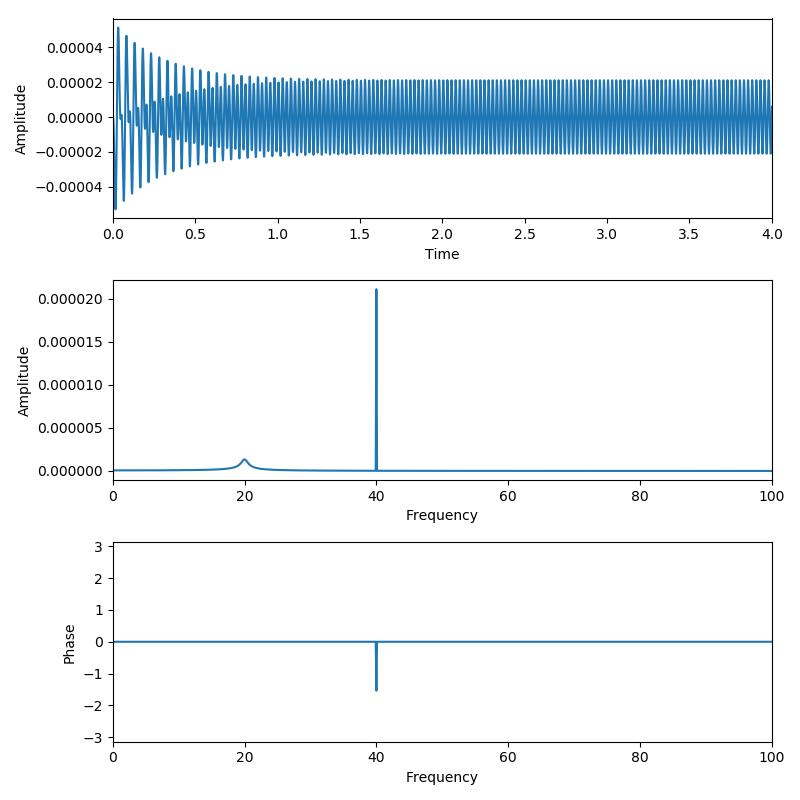

In [15]:
frequency, amplitude, phase = fftPlot(t, x)

## a)

From the following plot of $x(t)$ we can see that the system is described by a combination of two sinusoidal waves:
$$
x(t)=A\cos(\omega t - \delta) + A_{tr}e^{-\beta t}\cos(\omega_1 t - \delta_{tr})
$$
where the first term is the particular solution which describes a steady oscillation driven by the driving force. The second term is the homogenous solution, which describes the damped oscillation set by an initial condition. The amplitude of the damped oscillation decays as time goes on and eventually dies out at around $t=1.2$ as the damping force dissipates the initial potential energy of the system, leaving the driven oscillation which is kept steady by the periodic driving force.

<IPython.core.display.Javascript object>


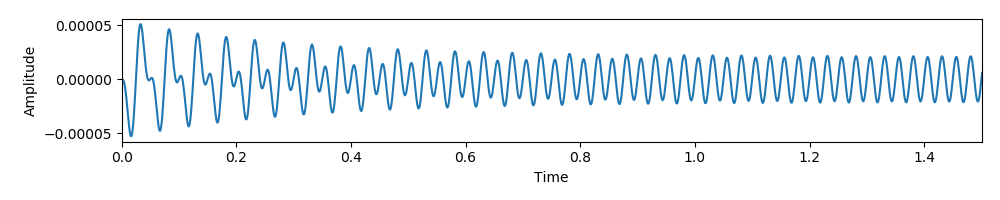

In [16]:
# plot the displacement as a function of time, focusing on 0 < t < 1.5
xmin = 0.
xmax = 1.5
plt.figure(figsize = (10, 2))    
plt.plot(t, x)
plt.xlim(xmin, xmax)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.tight_layout()

## b)

The following plot of amplitude as a function of frequency is the result of performing a Fourier Transform of the driven damped oscillation.

1. We can see a peak at the frequency of 40. Its **sharpness** indicates that it is a single sinusoidal wave with definitive frequency of 40 and constant amplitude of around 0.000021, which describes a steady oscillation driven by a periodic drivng force. Its **high amplitude** compared to waves of other frequencies indicates that it is the dominant sinusoidal wave in the Fourier series that expresses the system, which corresponds to the physical fact that the driving force keeps the oscillation steady and does not die out as time goes on.
2. The smooth peak at the frequency of 20 corresponds to the damped oscillation. Its **smoothness** indicates that it is itself a combination of various waves with frequencies ranging from around 15 to 25 and amplitude from 0 to aroud 0.0000013. We can infer that this is a wave of frequency 20 with varying amplitude, which is part of the characteristics of damped oscillation. We can **probably???** obtain its initial amplitude by integrating the amplitude with respect to frequency from 15 to 25. Its **low amplitude** compared to the peak at 40 indicates that it is not the dominant term in the Fourier series, which corresponds to the fact that the damped oscillation dies out as time goes on.

<IPython.core.display.Javascript object>


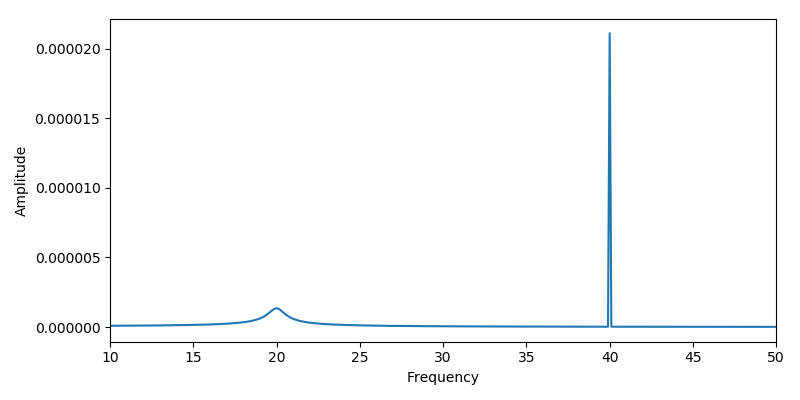

In [17]:
plt.figure(figsize = (8, 4))

plt.plot(frequency, amplitude)
plt.xlim(10., 50.)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.tight_layout()

## c)

Based on the plot in (b), the driving frequency:

$$
\begin{aligned}
\omega &= 2\pi f_{dr} = 2\pi\times 40\\\\
\omega &\approxeq 251.32741\\
\end{aligned}
$$  

We can also obtain $\omega$ by finding the driving period $\tau_{dr}$ through the data and calculate $\omega$ using:

$$
\omega = \frac{2\pi}{\tau_{dr}}
$$

In [18]:
# find period by picking the peak of the driving and taking the difference


## d)

Based on the plot in (b), the frequency of damped oscillator $\omega_1$:
$$
\begin{aligned}
\omega_1 &= 2\pi f_{dp} = 2\pi\times 20\\\\
\omega_1 &\approxeq 125.66371\\
\end{aligned}
$$  

## e)

The method in this question is from the Hint(1) in the Problem Set 4 Instruction.
Knowing the amplitude, angular frequency, and phase of the particular solution, we subtract it from the general solution, filtering out the contribution of the driving force, to obtain the $x(t)$ plotting of the damped oscillation. 
Then, by curve-fitting the logarithm of the amplitude of each cycle, we can calculate the damping constant $\beta$.

<IPython.core.display.Javascript object>


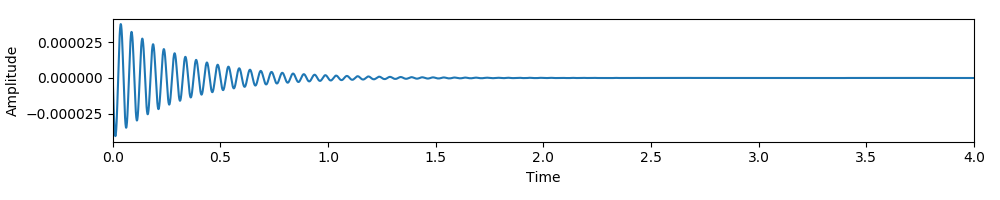

In [19]:
# the amplitude, frequency, and phase of the cosine term representing the driving force
amp = amplitude.max()
freq = 40 * 2 * np.pi
phs = min(filterPhase(amplitude, phase))

# the values of the cosine term representing the driving force at each time step 
# (displacement as a function of time if the driving force was the only source causing the oscillation)
x_dr = [amp*n for n in np.cos([freq*time+phs for time in t])]

# the term representing the pure under-damped oscillation is obtained by 
# subtracting the total function of the actual driven damped oscillation by the term of driving force
x_damped = list(map(lambda x, y: x-y, x, x_dr))

# for the under-damped oscillation, plot the displacement as a function of time
xmin = 0.
xmax = 4.0
plt.figure(figsize = (10, 2))
plt.plot(t, x_damped)
plt.xlim(xmin, xmax)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.tight_layout()

<IPython.core.display.Javascript object>


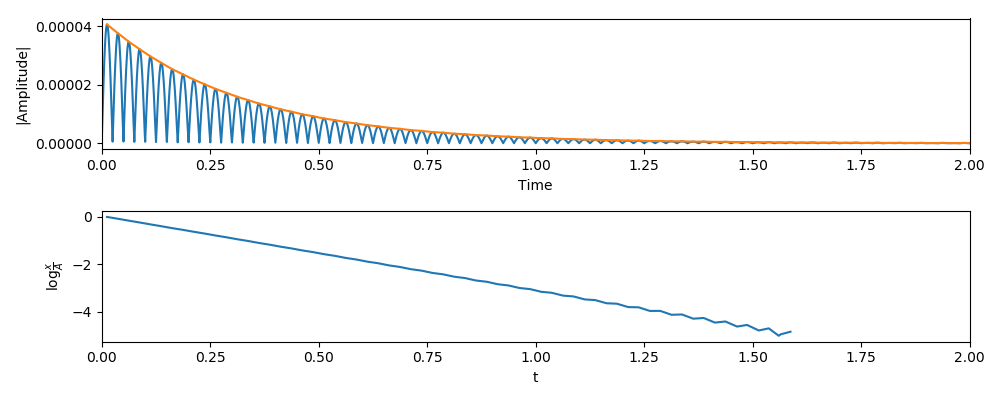

beta = 3.14016


In [20]:
# the absolute value of the function of damped oscillation
x_damped_abs = [np.abs(n) for n in x_damped]
# the index in the array "x_damped_abs" where the peaks of the function occur
peak_indices = find_peaks(x_damped_abs)[0]

# peak values and the corresponding time at which the peaks occur
times = [t[i] for i in peak_indices]
peaks = [x_damped_abs[i] for i in peak_indices]

# perform linear fit using data points in the interval 0 <= t <= 1.6
times_fit = [time for time in times if time <= 1.6]
peaks_fit = [np.log(peak/peaks[0]) for peak in peaks[: len(times_fit)]]
line_fit = np.polyfit(times_fit, peaks_fit, 1)
beta = 0 - line_fit[0]

xmin = 0.
xmax = 2.

fig, axs = plt.subplots(2, 1, figsize=(10, 4))

# plot the peak value curve
axs[0].plot(t, x_damped_abs)
axs[0].plot(times, peaks)
axs[0].set_xlim(xmin, xmax)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('|Amplitude|')

# plot the fitted line, of which the slope is the negative of Beta
axs[1].plot(times_fit, peaks_fit)
axs[1].set_xlim(xmin, xmax)
axs[1].set_xlabel('t')
axs[1].set_ylabel(r'$\log\frac{x}{A}$')
plt.tight_layout()

print('beta = %.5f'  %beta)
    

## f)

This is an underdamped oscillator.

Based on the first figure in (e), subtracting the driving sinusoidal wave from the combined wave results in a decaying sinusoidal wave, which is the characteristic of an underdamped oscillator.

For an underdamped oscillator, the frequecy of damped oscillator $\omega_1$, the natural frequency $\omega_0$, and the damping constant $\beta$ have the following relations:

$$
\omega_0 = \sqrt{\beta^2 + \omega_1^2}
$$

thus,

$$
\omega_0 = \sqrt{3.14^2 + 125.66371^2} \approxeq 125.70293
$$

## g)

For driven damped oscillator, we can calculate the value of $f_0$ using the equation $(69)$ in the oscillation notes:

$$
A^2 = \frac{f_0^2}{(\omega_0^2 - \omega^2)^2 + 4\beta^2\omega^2}
$$


In [22]:
w_0 = 125.70293
f_0 = np.sqrt(amp*amp*((w_0*w_0-freq*freq)*(w_0*w_0-freq*freq)+4*beta*beta*freq*freq))
print("f_0 = %0.8f" %f_0)

f_0 = 1.00071118


$f_0 = 1.00071118$